# Traffic Sign Classifier

# Part 1: Dataset Preparation

This notebook preprocesses the annotated traffic sign dataset by:
1. Reading the annotations CSV
2. Cropping each annotated sign from the original images
3. Organizing cropped signs by class for training

## Import Required Libraries

In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

Libraries imported successfully!


## Load and Explore Annotations

In [ ]:
annotations_path = 'db_lisa_tiny/annotations.csv'
df = pd.read_csv(annotations_path)

print(f"Total annotations: {len(df)}")

# Check class distribution
class_counts = df['class'].value_counts()
print(f"\n{'='*50}")
print("Class Distribution:")
print(f"{'='*50}")
for sign_class, count in class_counts.items():
    print(f"{sign_class:20s}: {count:4d} images")
print(f"{'='*50}")
print(f"Total unique classes: {len(class_counts)}")

Total annotations: 900

First few rows:
         filename   x1   y1   x2   y2 class
0  sample_001.png  190   40  211   63  stop
1  sample_002.png    4  246   43  283  stop
2  sample_003.png  389  286  418  314  stop
3  sample_004.png  307  243  315  251  stop
4  sample_005.png  377  249  398  270  stop
5  sample_006.png  476  137  514  174  stop
6  sample_007.png   30   26   54   50  stop
7  sample_008.png  388  289  407  309  stop
8  sample_009.png  489   17  528   53  stop
9  sample_010.png  406  241  418  254  stop

Class Distribution:
stop                :  210 images
speedLimit35        :  110 images
keepRight           :  110 images
signalAhead         :  100 images
merge               :  100 images
pedestrianCrossing  :  100 images
speedLimit25        :   80 images
yield               :   45 images
yieldAhead          :   45 images
Total unique classes: 9


## Crop and Save Traffic Signs

Each annotated sign must be cropped to mimic how the model would receive input from the detection model's output. The cropped images are then organized by class in a new directory structure:
```
cropped_signs/
> stop/
> speedLimit/
> ...
```

In [ ]:
# Crop traffic signs from images and organize by class.
def crop_and_save_signs(df, output_dir='cropped_signs', image_dir='db_lisa_tiny'):
    # Create output directory
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    
    # Statistics
    successful_crops = 0
    failed_crops = 0
    class_counters = {}
    
    print(f"Starting to crop {len(df)} traffic signs...")
    print("=" * 60)
    
    for idx, row in df.iterrows():
        try:
            # Load image
            img_path = Path(image_dir) / row['filename']
            img = Image.open(img_path)
            
            # Get bounding box coordinates
            x1, y1, x2, y2 = int(row['x1']), int(row['y1']), int(row['x2']), int(row['y2'])
            
            cropped_sign = img.crop((x1, y1, x2, y2))
            
            # Create class directory if it doesn't exist
            class_name = row['class']
            class_dir = output_path / class_name
            class_dir.mkdir(exist_ok=True)
            
            # Generate filename with counter for each class
            if class_name not in class_counters:
                class_counters[class_name] = 0
            class_counters[class_name] += 1
            
            # Save cropped sign
            output_filename = f"{class_name}_{class_counters[class_name]:04d}.png"
            output_file = class_dir / output_filename
            cropped_sign.save(output_file)
            
            successful_crops += 1
            
            # Progress update every 100 images
            if successful_crops % 100 == 0:
                print(f"Processed {successful_crops} images...")
                
        except Exception as e:
            print(f"Error processing {row['filename']}: {str(e)}")
            failed_crops += 1
    
    print("=" * 60)
    print(f"\n✓ Cropping complete!")
    print(f"  - Successfully cropped: {successful_crops}")
    print(f"  - Failed: {failed_crops}")
    print(f"\nCropped signs saved to: {output_path.absolute()}")
    print(f"\nBreakdown by class:")
    for class_name, count in sorted(class_counters.items()):
        print(f"  - {class_name:20s}: {count:4d} images")
    
    return class_counters

class_counters = crop_and_save_signs(df)

Starting to crop 900 traffic signs...
Processed 100 images...
Processed 100 images...
Processed 200 images...
Processed 200 images...
Processed 300 images...
Processed 300 images...
Processed 400 images...
Processed 400 images...
Processed 500 images...
Processed 500 images...
Processed 600 images...
Processed 600 images...
Processed 700 images...
Processed 700 images...
Processed 800 images...
Processed 800 images...
Processed 900 images...

✓ Cropping complete!
  - Successfully cropped: 900
  - Failed: 0

Cropped signs saved to: c:\Users\apurv\OneDrive\Desktop\Uni thingies\CptS 437\FinalProject\cropped_signs

Breakdown by class:
  - keepRight           :  110 images
  - merge               :  100 images
  - pedestrianCrossing  :  100 images
  - signalAhead         :  100 images
  - speedLimit25        :   80 images
  - speedLimit35        :  110 images
  - stop                :  210 images
  - yield               :   45 images
  - yieldAhead          :   45 images
Processed 900 image

<hr>

# Part 2: Building the model

## Setup for Classification

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
from glob import glob
import numpy as np
import shutil
from pathlib import Path
import matplotlib.pyplot as plt

# Check CUDA availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.1+cu126
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3070 Laptop GPU


## Create Train/Test Split

Create stratified train/test splits to ensure balanced class distribution.

In [ ]:
def create_train_test_split(cropped_dir='cropped_signs', test_size=0.2, val_size=0.1, random_state=42):
    cropped_path = Path(cropped_dir)
    
    # Collect all image paths and labels
    all_images = []
    all_labels = []
    
    for class_dir in cropped_path.iterdir():
        if class_dir.is_dir():
            class_name = class_dir.name
            images = list(class_dir.glob('*.png'))
            all_images.extend(images)
            all_labels.extend([class_name] * len(images))
    
    print(f"Total images: {len(all_images)}")
    print(f"Total classes: {len(set(all_labels))}")
    
    # First split: train+val vs test
    train_val_images, test_images, train_val_labels, test_labels = train_test_split(
        all_images, all_labels, test_size=test_size, stratify=all_labels, random_state=random_state
    )
    
    # Second split: train vs val
    val_size_adjusted = val_size / (1 - test_size)  # Adjust val_size relative to train+val
    train_images, val_images, train_labels, val_labels = train_test_split(
        train_val_images, train_val_labels, test_size=val_size_adjusted, 
        stratify=train_val_labels, random_state=random_state
    )
    
    # Create directory structure
    splits = {
        'train': (train_images, train_labels),
        'val': (val_images, val_labels),
        'test': (test_images, test_labels)
    }
    
    split_stats = {}
    
    for split_name, (images, labels) in splits.items():
        split_dir = Path(f'data/{split_name}')
        
        # Create class subdirectories
        for class_name in set(all_labels):
            class_dir = split_dir / class_name
            class_dir.mkdir(parents=True, exist_ok=True)
        
        # Copy images to appropriate directories
        class_counts = {}
        for img_path, label in zip(images, labels):
            dest_dir = split_dir / label
            dest_path = dest_dir / img_path.name
            
            # Copy file
            shutil.copy2(img_path, dest_path)
            
            class_counts[label] = class_counts.get(label, 0) + 1
        
        split_stats[split_name] = {
            'total': len(images),
            'classes': class_counts
        }
    
    # Print statistics
    print("\n" + "="*60)
    print("DATASET SPLIT SUMMARY")
    print("="*60)
    
    for split_name, stats in split_stats.items():
        print(f"\n{split_name.upper()} SET: {stats['total']} images")
        for class_name, count in sorted(stats['classes'].items()):
            percentage = (count / stats['total']) * 100
            print(f"  {class_name:20s}: {count:4d} ({percentage:5.1f}%)")
    
    print("="*60)
    print(f"\nDataset split completed and saved to 'data/' directory!")
    
    return split_stats

split_stats = create_train_test_split(test_size=0.2, val_size=0.1)

Total images: 900
Total classes: 9

DATASET SPLIT SUMMARY

TRAIN SET: 630 images
  keepRight           :   77 ( 12.2%)
  merge               :   70 ( 11.1%)
  pedestrianCrossing  :   70 ( 11.1%)
  signalAhead         :   70 ( 11.1%)
  speedLimit25        :   56 (  8.9%)
  speedLimit35        :   77 ( 12.2%)
  stop                :  147 ( 23.3%)
  yield               :   31 (  4.9%)
  yieldAhead          :   32 (  5.1%)

VAL SET: 90 images
  keepRight           :   11 ( 12.2%)
  merge               :   10 ( 11.1%)
  pedestrianCrossing  :   10 ( 11.1%)
  signalAhead         :   10 ( 11.1%)
  speedLimit25        :    8 (  8.9%)
  speedLimit35        :   11 ( 12.2%)
  stop                :   21 ( 23.3%)
  yield               :    5 (  5.6%)
  yieldAhead          :    4 (  4.4%)

TEST SET: 180 images
  keepRight           :   22 ( 12.2%)
  merge               :   20 ( 11.1%)
  pedestrianCrossing  :   20 ( 11.1%)
  signalAhead         :   20 ( 11.1%)
  speedLimit25        :   16 (  8.9%)
  s

## Data Augmentation Pipeline

Implement augmentations to be compatible witrh ResNet50 model (ie, Resize and Normalization)

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Training transforms: light augmentation to reduce overfitting
train_transforms = A.Compose([
    A.Resize(224, 224),
    A.Rotate(limit=10, p=0.3),  # Light rotation
    A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.3),
    A.GaussNoise(var_limit=(5.0, 15.0), p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# Validation/Test transforms: only resize and normalize
val_transforms = A.Compose([
    A.Resize(224, 224), # ResNet 
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

C:\Users\apurv\AppData\Local\Temp\ipykernel_4400\695615943.py:9: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 15.0), p=0.2),


## Custom Dataset Class

This will help load images and labels from the cropped signs directory and apply transformations.

In [55]:
class TrafficSignDataset(Dataset):
    
    def __init__(self, data_dir, transform=None):
        self.data_dir = Path(data_dir)
        self.transform = transform
        
        # Collect all image paths and labels
        self.images = []
        self.labels = []
        self.class_names = sorted([d.name for d in self.data_dir.iterdir() if d.is_dir()])
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.class_names)}
        
        for class_name in self.class_names:
            class_dir = self.data_dir / class_name
            class_images = list(class_dir.glob('*.png'))
            self.images.extend(class_images)
            self.labels.extend([self.class_to_idx[class_name]] * len(class_images))
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        
        # Load image
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Apply transforms
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        return image, label

# Create datasets
train_dataset = TrafficSignDataset('data/train', transform=train_transforms)
val_dataset = TrafficSignDataset('data/val', transform=val_transforms)
test_dataset = TrafficSignDataset('data/test', transform=val_transforms)

print(f"Train dataset: {len(train_dataset)} images")
print(f"Val dataset: {len(val_dataset)} images")
print(f"Test dataset: {len(test_dataset)} images")
print(f"\nClasses ({len(train_dataset.class_names)}): {train_dataset.class_names}")

Train dataset: 630 images
Val dataset: 90 images
Test dataset: 180 images

Classes (9): ['keepRight', 'merge', 'pedestrianCrossing', 'signalAhead', 'speedLimit25', 'speedLimit35', 'stop', 'yield', 'yieldAhead']


In [56]:
# Create data loaders
batch_size = 64 # Reduce to 32 if GPU memory is limited

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Batch size: {batch_size}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Batch size: 64
Train batches: 10
Val batches: 2
Test batches: 3


## Transfer Learning Model

Use a pretrained ImageNet backbone (ResNet50) with transfer learning.

In [ ]:
# Create ResNet50 model with ImageNet pretrained weights.
# Replace final layer for traffic sign classification.
def create_model(num_classes, pretrained=True):
    # Load pretrained ResNet50
    model = models.resnet50(pretrained=pretrained)
    
    # Freeze early layers, keep layer4 trainable for better feature learning
    for param in model.layer1.parameters():
        param.requires_grad = False
    for param in model.layer2.parameters():
        param.requires_grad = False
    for param in model.layer3.parameters():
        param.requires_grad = False
    
    num_features = model.fc.in_features

    model.fc = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, num_classes)
    )
        
    return model

# Create model
num_classes = len(train_dataset.class_names)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_model(num_classes).to(device)

print(model.fc)

print(f"Model created with {num_classes} output classes")
print(f"Using device: {device}")

c:\Users\apurv\OneDrive\Desktop\Uni thingies\CptS 437\FinalProject\TrafficSignClassifier\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\apurv\OneDrive\Desktop\Uni thingies\CptS 437\FinalProject\TrafficSignClassifier\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.4, inplace=False)
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.3, inplace=False)
  (8): Linear(in_features=256, out_features=9, bias=True)
)
Model created with 9 output classes
Using device: cuda


## Training Setup

In [89]:
# Calculate class weights to handle imbalance
from collections import Counter

class_counts = Counter(train_dataset.labels)
total_samples = len(train_dataset)
class_weights = torch.tensor([total_samples / (len(class_counts) * class_counts[i]) 
                               for i in range(len(train_dataset.class_names))], 
                              dtype=torch.float32).to(device)

print("Class Weights (to balance training):")
print("="*60)
for i, cls_name in enumerate(train_dataset.class_names):
    print(f"{cls_name:20s}: weight={class_weights[i]:.3f} (count={class_counts[i]})")
print("="*60)

Class Weights (to balance training):
keepRight           : weight=0.909 (count=77)
merge               : weight=1.000 (count=70)
pedestrianCrossing  : weight=1.000 (count=70)
signalAhead         : weight=1.000 (count=70)
speedLimit25        : weight=1.250 (count=56)
speedLimit35        : weight=0.909 (count=77)
stop                : weight=0.476 (count=147)
yield               : weight=2.258 (count=31)
yieldAhead          : weight=2.188 (count=32)


In [ ]:
# Loss function with label smoothing and class weights to handle imbalance
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

# Optimizer with learning rates
optimizer = optim.Adam([
    {'params': model.layer4.parameters(), 'lr': 0.0001},  # lower LR for pretrained layer
    {'params': model.fc.parameters(), 'lr': 0.001} # note: prev 0.001
])

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Iterate over data batches
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Disable gradient computation for validation
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

## Train the Model

In [92]:
# Training loop
num_epochs = 30 # >40 seems unnecessary
best_val_acc = 0
best_val_acc_early = 0  # Best model in epochs 0-5
best_val_acc_mid = 0    # Best model in epochs 5-10
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("Starting training...\n")

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Save best model overall
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f">> Saved best model (val_acc: {val_acc:.2f}%)")
    
    # Save best model from epochs 0-5 (early training)
    if epoch < 5 and val_acc > best_val_acc_early:
        best_val_acc_early = val_acc
        torch.save(model.state_dict(), 'best_model_early.pth')
        print(f">> Saved best early model (epochs 0-5, val_acc: {val_acc:.2f}%)")
    
    # Save best model from epochs 5-10 (mid training)
    if 5 <= epoch < 10 and val_acc > best_val_acc_mid:
        best_val_acc_mid = val_acc
        torch.save(model.state_dict(), 'best_model_mid.pth')
        print(f">> Saved best mid model (epochs 5-10, val_acc: {val_acc:.2f}%)")
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

print(f"\nTraining complete!")
print(f"Best validation accuracy (overall): {best_val_acc:.2f}%")
print(f"Best validation accuracy (epochs 0-5): {best_val_acc_early:.2f}%")
print(f"Best validation accuracy (epochs 5-10): {best_val_acc_mid:.2f}%")

Starting training...

>> Saved best model (val_acc: 64.44%)
>> Saved best early model (epochs 0-5, val_acc: 64.44%)
Epoch [1/30] Train Loss: 1.7099, Train Acc: 46.67% | Val Loss: 1.5895, Val Acc: 64.44%
>> Saved best model (val_acc: 64.44%)
>> Saved best early model (epochs 0-5, val_acc: 64.44%)
Epoch [1/30] Train Loss: 1.7099, Train Acc: 46.67% | Val Loss: 1.5895, Val Acc: 64.44%
>> Saved best model (val_acc: 85.56%)
>> Saved best early model (epochs 0-5, val_acc: 85.56%)
Epoch [2/30] Train Loss: 1.1369, Train Acc: 76.35% | Val Loss: 0.9612, Val Acc: 85.56%
>> Saved best model (val_acc: 85.56%)
>> Saved best early model (epochs 0-5, val_acc: 85.56%)
Epoch [2/30] Train Loss: 1.1369, Train Acc: 76.35% | Val Loss: 0.9612, Val Acc: 85.56%
>> Saved best model (val_acc: 91.11%)
>> Saved best early model (epochs 0-5, val_acc: 91.11%)
Epoch [3/30] Train Loss: 0.9250, Train Acc: 86.35% | Val Loss: 0.7823, Val Acc: 91.11%
>> Saved best model (val_acc: 91.11%)
>> Saved best early model (epochs 0

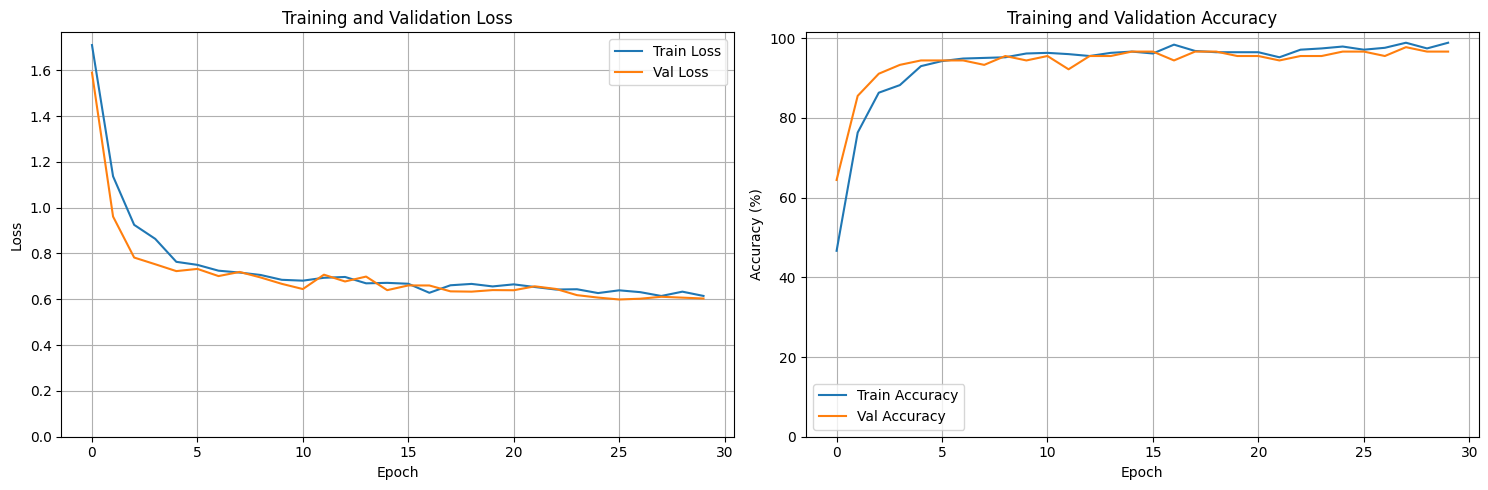

In [93]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss
ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['val_loss'], label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_ylim(bottom=0)
ax1.legend()
ax1.grid(True)

# Accuracy
ax2.plot(history['train_acc'], label='Train Accuracy')
ax2.plot(history['val_acc'], label='Val Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.set_ylim(bottom=0)
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## Evaluation: Top-1 Accuracy, F1 Scores, Confusion Matrix

Comprehensive evaluation as requested by professor.

In [ ]:
# Load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Get predictions on test set
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate Top-1 Accuracy
top1_accuracy = 100. * (all_preds == all_labels).sum() / len(all_labels)

print("="*60)
print("TEST SET EVALUATION")
print("="*60)
print(f"\n✓ Top-1 Accuracy: {top1_accuracy:.2f}%\n")

# Per-class classification report with F1 scores
print("Per-Class Metrics:")
print("="*60)
report = classification_report(all_labels, all_preds, 
                                target_names=test_dataset.class_names,
                                digits=4)
print(report)

TEST SET EVALUATION

✓ Top-1 Accuracy: 95.56%

Per-Class Metrics:
                    precision    recall  f1-score   support

         keepRight     1.0000    0.9545    0.9767        22
             merge     1.0000    0.9500    0.9744        20
pedestrianCrossing     0.9474    0.9000    0.9231        20
       signalAhead     0.9048    0.9500    0.9268        20
      speedLimit25     0.8889    1.0000    0.9412        16
      speedLimit35     0.9524    0.9091    0.9302        22
              stop     0.9545    1.0000    0.9767        42
             yield     1.0000    1.0000    1.0000         9
        yieldAhead     1.0000    0.8889    0.9412         9

          accuracy                         0.9556       180
         macro avg     0.9609    0.9503    0.9545       180
      weighted avg     0.9573    0.9556    0.9555       180



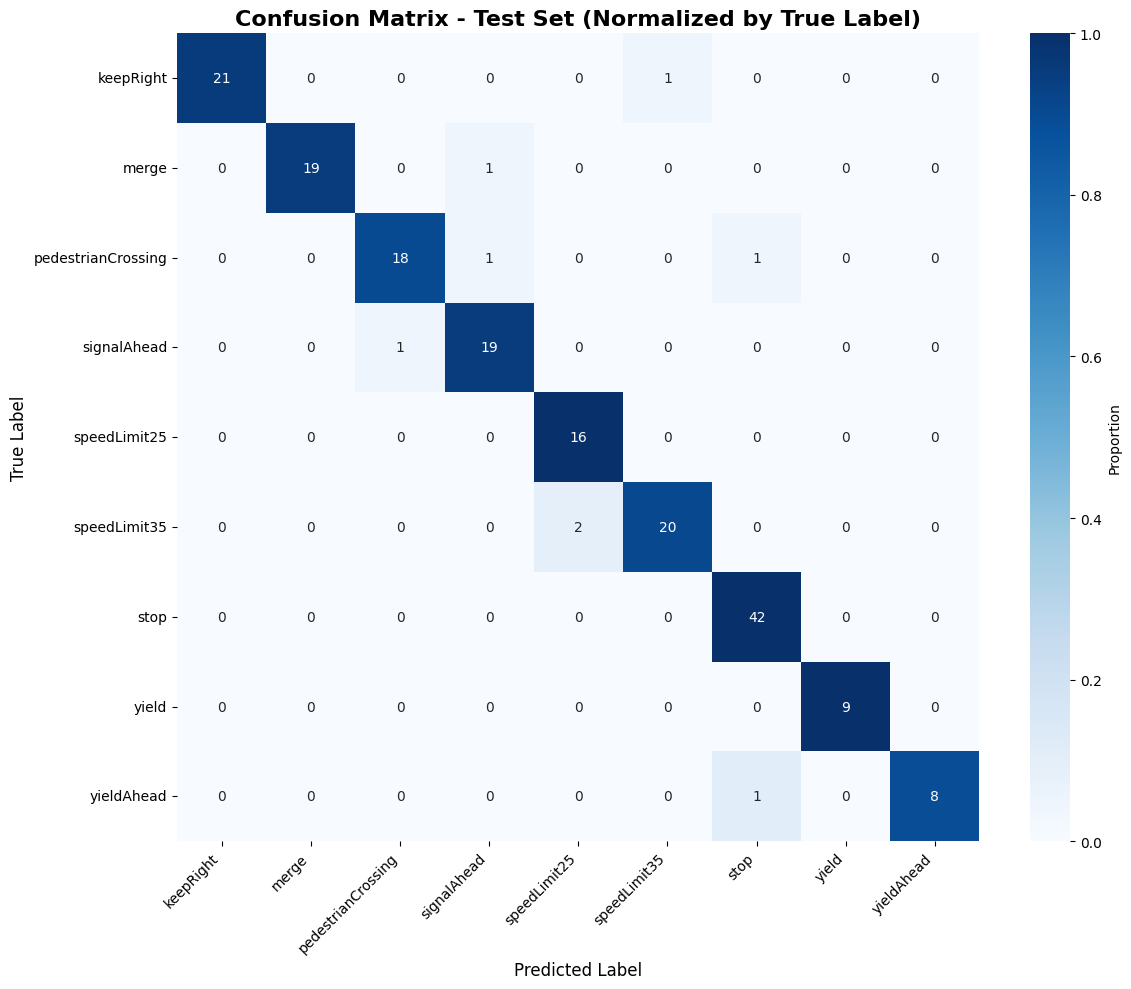

In [109]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Normalize by row (true labels) to show proportions
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues', vmin=0, vmax=1,
            xticklabels=test_dataset.class_names,
            yticklabels=test_dataset.class_names,
            cbar_kws={'label': 'Proportion'})
plt.title('Confusion Matrix - Test Set (Normalized by True Label)', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

## Error Analysis

Identify and visualize misclassified examples to understand model weaknesses.

In [110]:
# Find misclassified examples
misclassified_indices = np.where(all_preds != all_labels)[0]
print(f"Total misclassifications: {len(misclassified_indices)} / {len(all_labels)}")
print(f"Error rate: {100 * len(misclassified_indices) / len(all_labels):.2f}%")

# Analyze error patterns
error_patterns = {}
for idx in misclassified_indices:
    true_class = test_dataset.class_names[all_labels[idx]]
    pred_class = test_dataset.class_names[all_preds[idx]]
    
    key = f"{true_class} → {pred_class}"
    error_patterns[key] = error_patterns.get(key, 0) + 1

# Show top 10 most common errors
print("\n" + "="*60)
print("TOP 10 MOST COMMON MISCLASSIFICATIONS")
print("="*60)
sorted_errors = sorted(error_patterns.items(), key=lambda x: x[1], reverse=True)
for i, (pattern, count) in enumerate(sorted_errors[:10], 1):
    print(f"{i:2d}. {pattern:40s}: {count:3d} errors")

Total misclassifications: 8 / 180
Error rate: 4.44%

TOP 10 MOST COMMON MISCLASSIFICATIONS
 1. speedLimit35 → speedLimit25             :   2 errors
 2. keepRight → speedLimit35                :   1 errors
 3. merge → signalAhead                     :   1 errors
 4. pedestrianCrossing → signalAhead        :   1 errors
 5. pedestrianCrossing → stop               :   1 errors
 6. signalAhead → pedestrianCrossing        :   1 errors
 7. yieldAhead → stop                       :   1 errors


In [ ]:
def predict_custom_image(image_path, model, device, class_names):
    """
    Predict traffic sign class for a custom image.
    
    Args:
        image_path: Path to the image file
        model: Trained model
        device: Device (CPU/GPU)
        class_names: List of class names
    
    Returns:
        Predicted class name and confidence scores
    """
    # Load image
    image = cv2.imread(str(image_path))
    if image is None:
        print(f"Error: Could not load image from {image_path}")
        return None, None
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Apply validation transforms
    transformed = val_transforms(image=image_rgb)
    image_tensor = transformed['image'].unsqueeze(0).to(device)
    
    # Get prediction
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        confidence, predicted = probabilities.max(1)
    
    predicted_class = class_names[predicted.item()]
    confidence_score = confidence.item() * 100
    
    # Get top 3 predictions
    top3_prob, top3_idx = torch.topk(probabilities, 3)
    top3_classes = [(class_names[idx.item()], prob.item() * 100) 
                    for idx, prob in zip(top3_idx[0], top3_prob[0])]
    
    return predicted_class, confidence_score, top3_classes, image_rgb


def visualize_prediction(image_path, model, device, class_names):
    """Visualize prediction with image and top predictions"""
    result = predict_custom_image(image_path, model, device, class_names)
    
    if result[0] is None:
        return
    
    predicted_class, confidence, top3, image_rgb = result
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1.imshow(image_rgb)
    ax1.set_title(f"Prediction: {predicted_class}\nConfidence: {confidence:.2f}%", 
                  fontsize=14, fontweight='bold')
    ax1.axis('off')
    
    # Show top 3 predictions
    classes = [cls for cls, _ in top3]
    confidences = [conf for _, conf in top3]
    colors = ['green' if i == 0 else 'lightblue' for i in range(len(classes))]
    
    y_pos = np.arange(len(classes))
    ax2.barh(y_pos, confidences, color=colors)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(classes)
    ax2.set_xlabel('Confidence (%)', fontsize=12)
    ax2.set_title('Top 3 Predictions', fontsize=14, fontweight='bold')
    ax2.set_xlim([0, 100])
    
    # Add percentage labels
    for i, (cls, conf) in enumerate(top3):
        ax2.text(conf + 2, i, f'{conf:.1f}%', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()


Visualizing 8 misclassified examples:


Misclassification 1:
True: keepRight | Predicted: speedLimit35


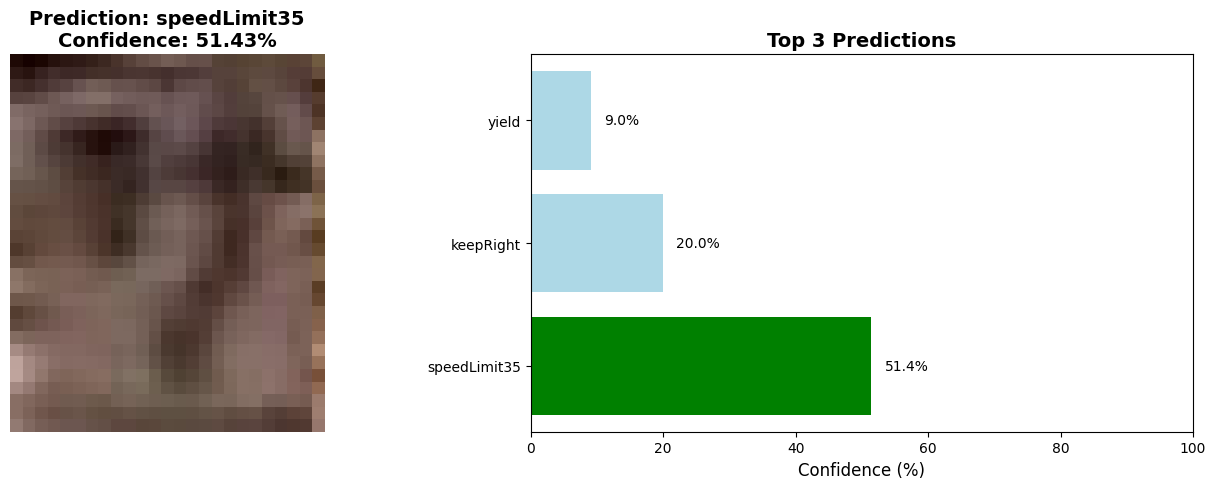


Misclassification 2:
True: merge | Predicted: signalAhead


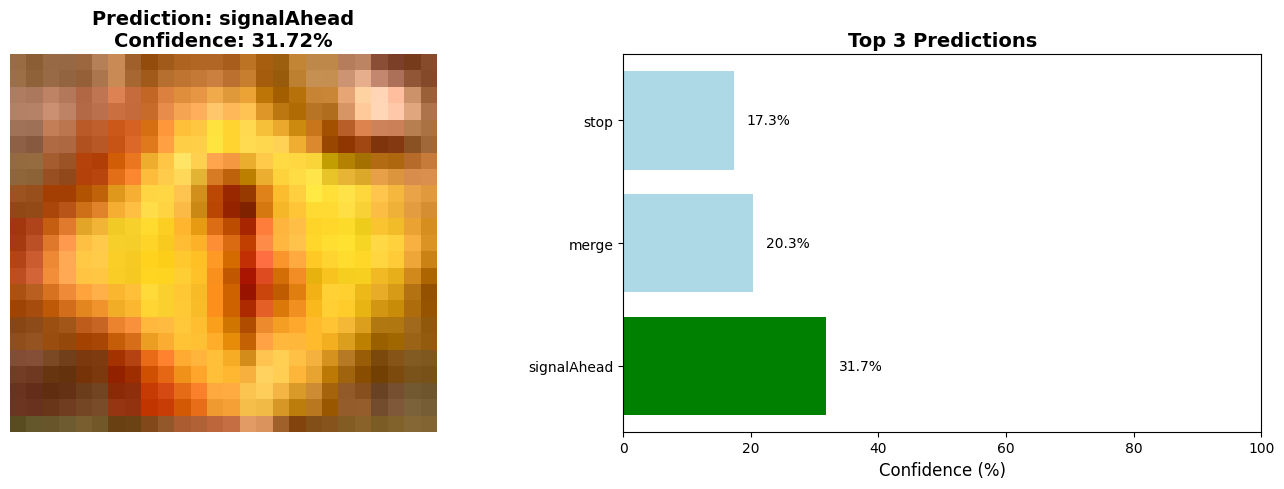


Misclassification 3:
True: pedestrianCrossing | Predicted: signalAhead


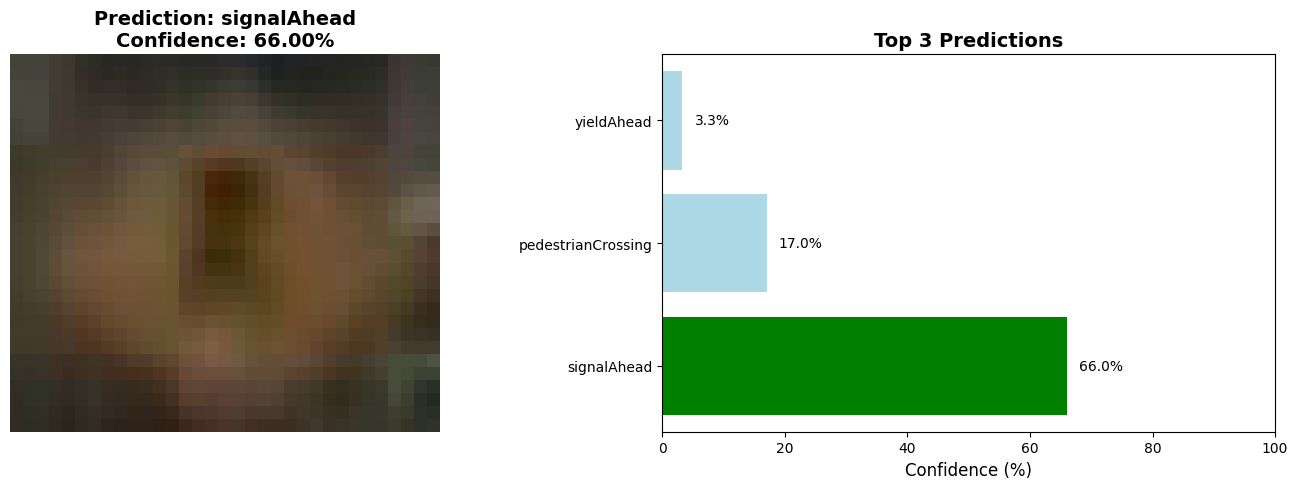


Misclassification 4:
True: pedestrianCrossing | Predicted: stop


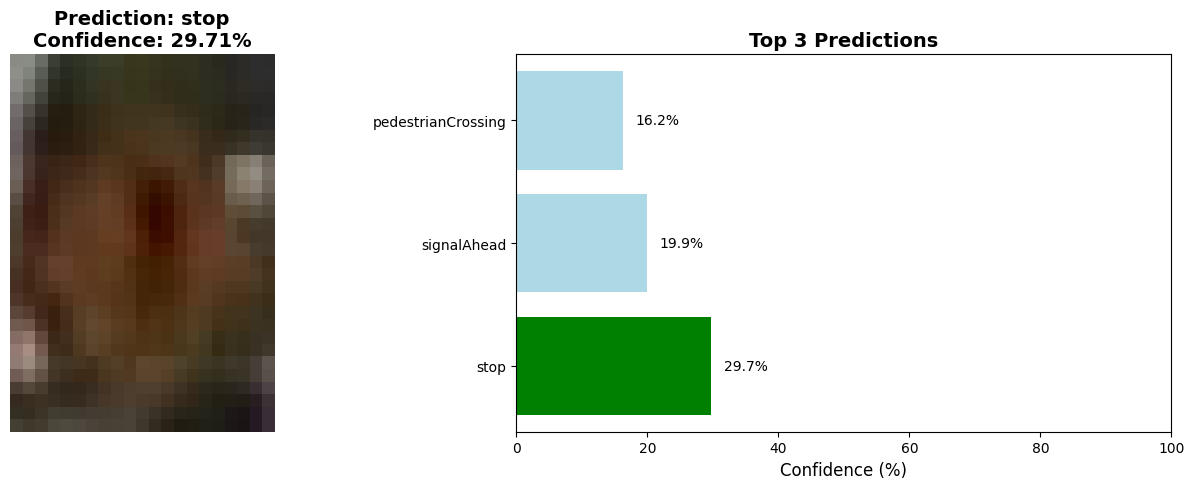


Misclassification 5:
True: signalAhead | Predicted: pedestrianCrossing


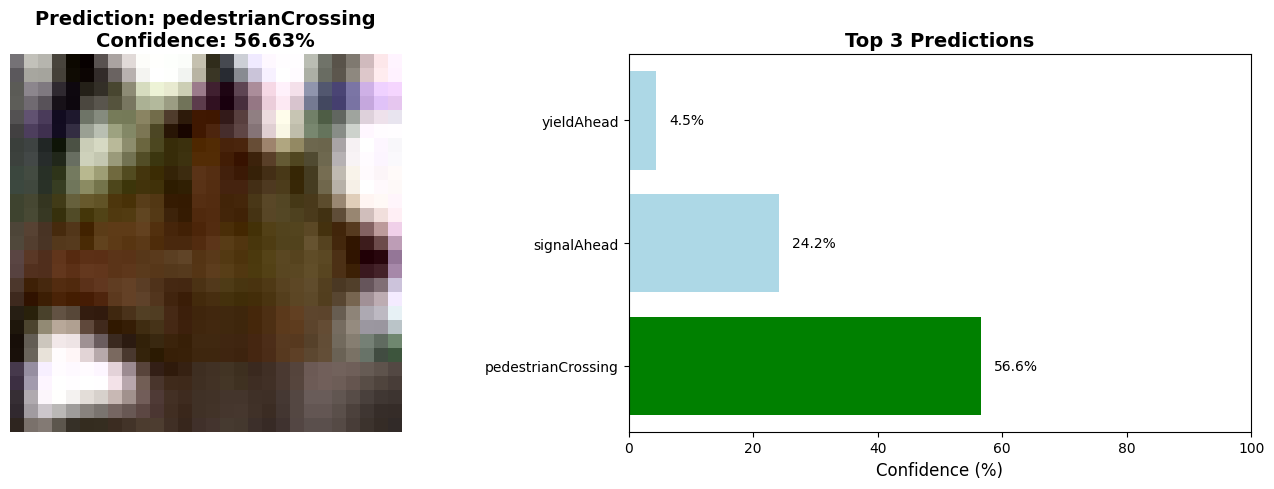


Misclassification 6:
True: speedLimit35 | Predicted: speedLimit25


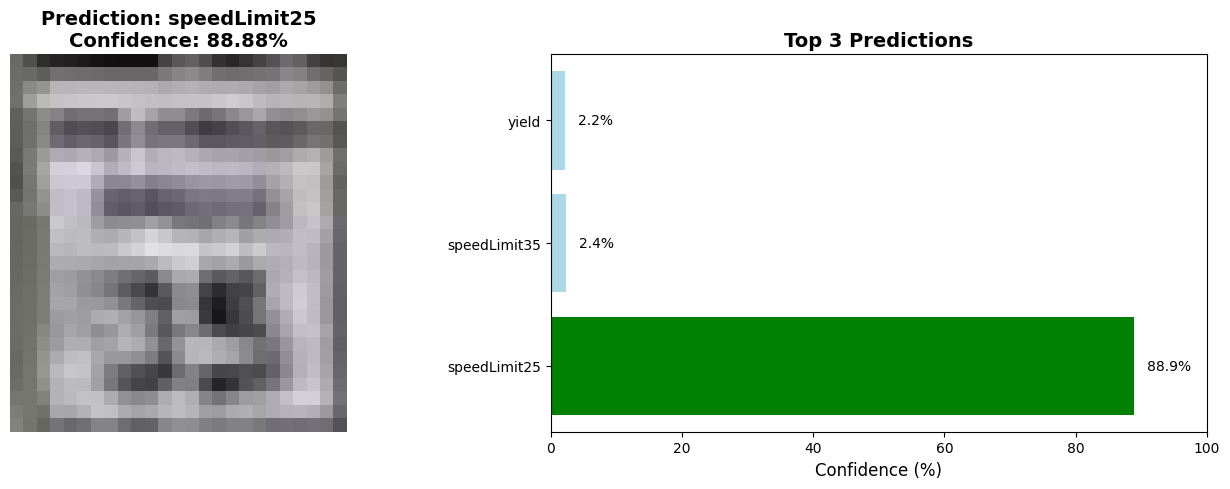


Misclassification 7:
True: speedLimit35 | Predicted: speedLimit25


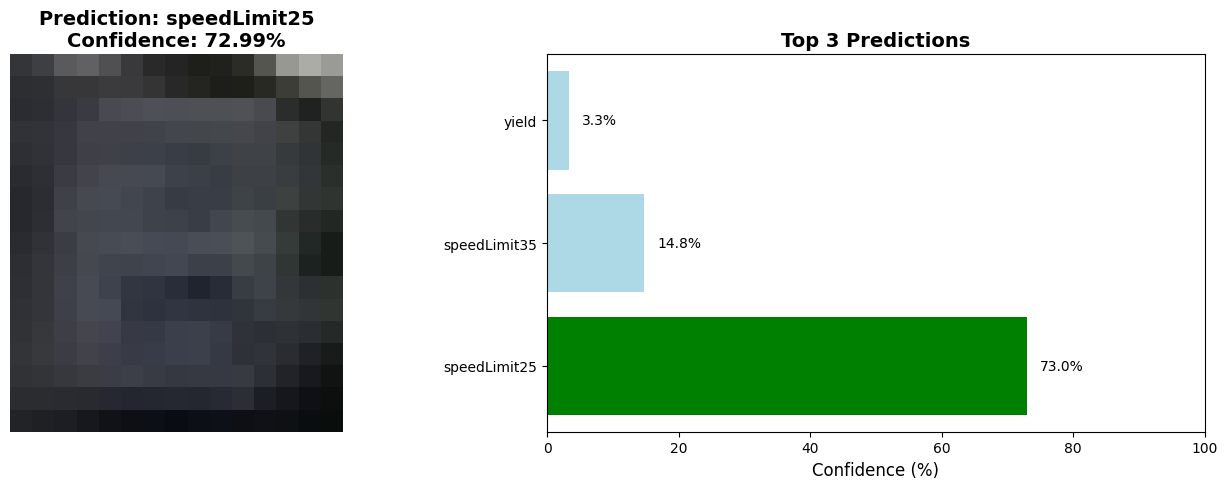


Misclassification 8:
True: yieldAhead | Predicted: stop


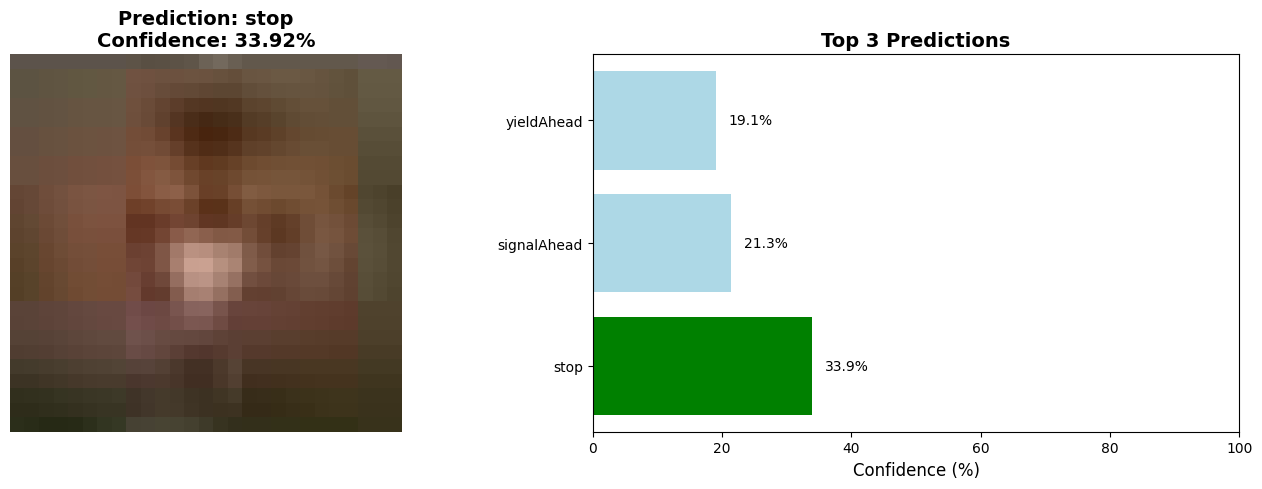

In [112]:
# Visualize misclassified examples
print(f"\nVisualizing {min(10, len(misclassified_indices))} misclassified examples:\n")

for i, idx in enumerate(misclassified_indices[:10]):
    img_path = test_dataset.images[idx]
    true_label = test_dataset.class_names[all_labels[idx]]
    pred_label = test_dataset.class_names[all_preds[idx]]
    
    print(f"\nMisclassification {i+1}:")
    print(f"True: {true_label} | Predicted: {pred_label}")
    
    visualize_prediction(img_path, model, device, test_dataset.class_names)

### Custom Image test

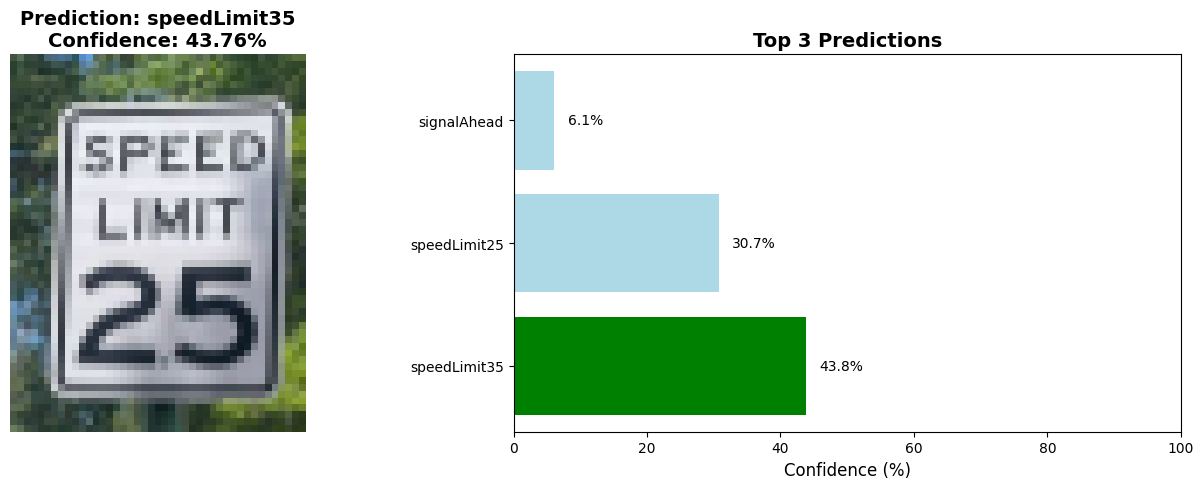

In [113]:
test_image_path = './custom_tests/test8.png'

visualize_prediction(test_image_path, model, device, test_dataset.class_names)